In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from utils import read_log
from math import log, sqrt
from statistics import NormalDist

In [2]:
class BlackScholes:
    def __init__(self, spot, strike, time_to_expiry):
        self.spot = spot
        self.strike = strike
        self.time_to_expiry = time_to_expiry

    def call_price(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        d2 = d1 - volatility * sqrt(self.time_to_expiry)
        call_price = self.spot * NormalDist().cdf(d1) - self.strike * NormalDist().cdf(d2)
        return call_price

    def delta(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().cdf(d1)

    def gamma(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().pdf(d1) / (self.spot * volatility * sqrt(self.time_to_expiry))

    def vega(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().pdf(d1) * (self.spot * sqrt(self.time_to_expiry)) / 100

    def implied_volatility(self, market_call_price, max_iterations=200, tolerance=1e-10):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = self.call_price(volatility)
            diff = estimated_price - market_call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [3]:
def calc_time_to_expiry(day, ts):
    return (8 - day) / 250 - ts / 1_000_000 / 250

In [4]:
def calc_implied_vol(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.implied_volatility(x['filtered_mid'])
    # return bs.implied_volatility(x['mid_price'])

In [5]:
def calc_delta(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.delta(x['implied_vol'])

In [6]:
def calc_gamma(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.gamma(x['implied_vol'])

In [7]:
def calc_vega(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.vega(x['implied_vol'])

In [8]:
def calc_moneyness(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    return np.log(x['strike'] / x['spot']) / np.sqrt(tte)

# Round 3

In [28]:
price_0 = pd.read_csv('../data/raw/round_3/prices_round_3_day_0.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_3/prices_round_3_day_1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')
price_3 = pd.read_csv('../data/raw/round_4/prices_round_4_day_3.csv', delimiter=';')

In [30]:
trades_0 = pd.read_csv('../data/raw/round_3/trades_round_3_day_0.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_3/trades_round_3_day_1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_3/trades_round_3_day_2.csv', delimiter=';')
trades_3 = pd.read_csv('../data/raw/round_4/trades_round_4_day_3.csv', delimiter=';')

In [40]:
prices = pd.concat([price_0, price_1, price_2, price_3], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2, trades_3], axis=0).reset_index(drop=True)

In [41]:
rock = prices[prices['product'] == 'VOLCANIC_ROCK'].reset_index(drop=True)
call_0 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'].reset_index(drop=True)
call_1 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'].reset_index(drop=True)
call_2 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'].reset_index(drop=True)
call_3 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'].reset_index(drop=True)
call_4 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'].reset_index(drop=True)

call_0 = call_0.assign(strike=9500)
call_1 = call_1.assign(strike=9750)
call_2 = call_2.assign(strike=10000)
call_3 = call_3.assign(strike=10250)
call_4 = call_4.assign(strike=10500)

calls = [call_0, call_1, call_2, call_3, call_4]
for call in calls:
    call['spot'] = rock['mid_price']
    call['intrinsic'] = np.max([call['spot'] - call['strike'], np.zeros(call.shape[0])], axis=0)
    call['filtered_mid'] = call.apply(lambda x: x['intrinsic'] if x['mid_price'] < x['intrinsic'] else x['mid_price'], axis=1)
    call['implied_vol'] = call.apply(calc_implied_vol, axis=1)

    call['vega'] = call.apply(calc_vega, axis=1)
    call['implied_vol'] = call.apply(lambda x: x['implied_vol'] if x['vega'] > 1e-6 else None, axis=1)  # filter 0 vega
    
    call['delta'] = call.apply(calc_delta, axis=1)
    call['gamma'] = call.apply(calc_gamma, axis=1)
    call['vega'] = call.apply(calc_vega, axis=1)

    call['moneyness'] = call.apply(calc_moneyness, axis=1)

In [42]:
# m_list, v_list = [], []
# for call in calls:
#     for i in range(1000, 1050):
#         call_i = call.iloc[i]
#         if not np.isnan(call_i['moneyness']) and not np.isnan(call_i['implied_vol']):
#             m_list.append(call_i['moneyness'])
#             v_list.append(call_i['implied_vol'])

m_list, v_list = [], []
for call in calls:
    call_i = call.iloc[1050]
    if not np.isnan(call_i['moneyness']) and not np.isnan(call_i['implied_vol']):
        m_list.append(call_i['moneyness'])
        v_list.append(call_i['implied_vol'])

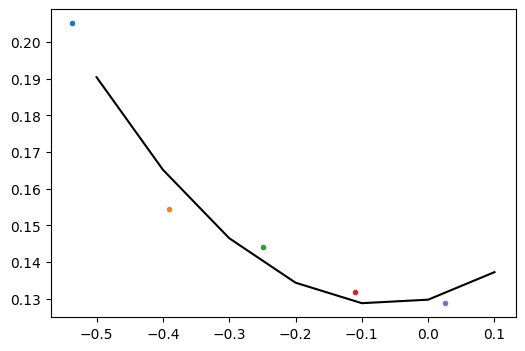

In [43]:
a, b, c = np.polyfit(m_list, v_list, 2)
modelled = a * (np.arange(-5, 2) / 10) ** 2 + b * np.arange(-5, 2) / 10 + c

plt.figure(figsize=(6, 4))
for call in calls:
    # call = call.iloc[1000:1050]
    call = call.iloc[1050]
    plt.scatter(call['moneyness'], call['implied_vol'], marker='.')
plt.plot(np.arange(-5, 2) / 10, modelled, c='k')
plt.show()

In [44]:
modelled[-2], c

(np.float64(0.129691374057696), np.float64(0.129691374057696))

In [51]:
thr = 10

base_ivs = []
for i in range(thr, 40000):
    m_list, v_list = [], []
    for call in calls:
        for ii in range(i - thr, i + 1):
            call_i = call.iloc[ii]
            if not np.isnan(call_i['moneyness']) and not np.isnan(call_i['implied_vol']):
                m_list.append(call_i['moneyness'])
                v_list.append(call_i['implied_vol'])
    coeffs = np.polyfit(m_list, v_list, 2)  # coeffs = [a, b, c]
    base_iv = coeffs[2]
    if base_iv > 0:
        base_ivs.append(base_iv)
    else:
        base_ivs.append(v_list[list(np.argsort(np.abs(np.array(m_list))))[0]])
base_ivs = pd.Series(base_ivs).dropna()

# base_ivs = []
# for i in range(30000):
#     m_list, v_list = [], []
#     for call in calls:
#         call_i = call.iloc[i]
#         if not np.isnan(call_i['moneyness']) and not np.isnan(call_i['implied_vol']):
#             m_list.append(call_i['moneyness'])
#             v_list.append(call_i['implied_vol'])
#     coeffs = np.polyfit(m_list, v_list, 2)  # coeffs = [a, b, c]
#     base_iv = coeffs[2]
#     if base_iv > 0:
#         base_ivs.append(base_iv)
#     else:
#         base_ivs.append(v_list[list(np.argsort(np.abs(np.array(m_list))))[0]])
# base_ivs = pd.Series(base_ivs).dropna()

In [80]:
base_ivs.mean()

np.float64(0.12401215640032288)

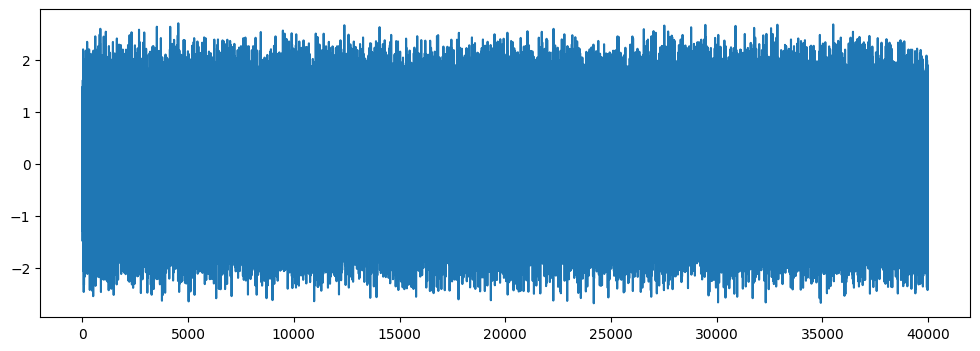

In [87]:
base_iv_z_score = (base_ivs - base_ivs.rolling(thr).mean()) / base_ivs.rolling(thr).std()
# base_iv_z_score = (base_ivs - base_ivs.mean()) / base_ivs.rolling(thr).std()
plt.figure(figsize=(12, 4))
plt.plot(base_iv_z_score)
# plt.plot(base_ivs)
# plt.axhline(base_ivs.mean(), c='k')
plt.show()

In [91]:
norm.mean(), norm.std()

(np.float64(0.12401215640032288), np.float64(0.003231211999104162))

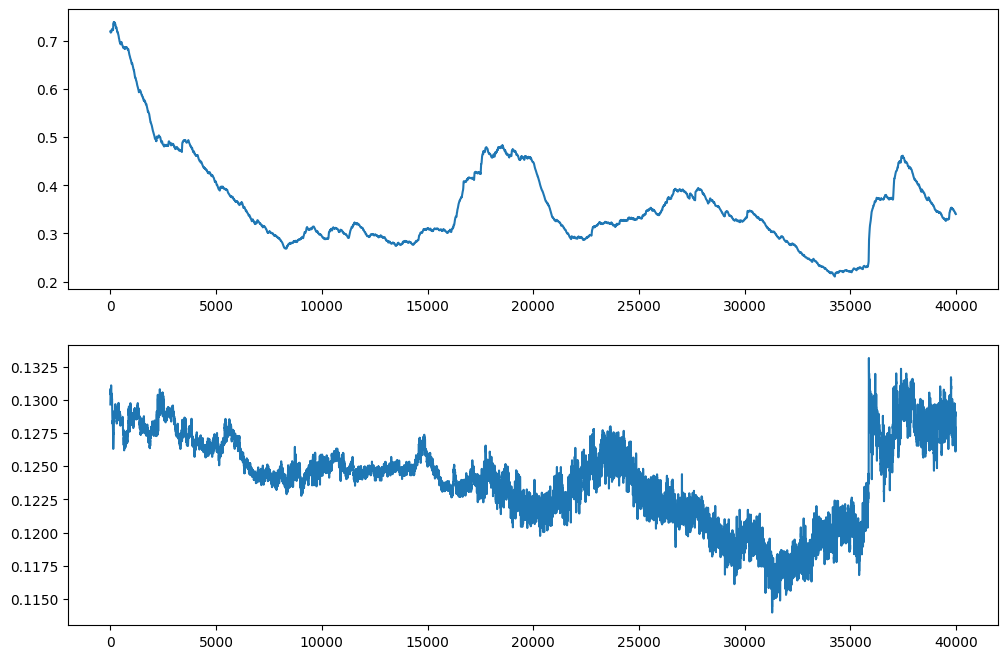

In [94]:
realized_vol = np.log(rock['mid_price'] / rock['mid_price'].shift(1)).rolling(thr).std().dropna().reset_index(drop=True) * np.sqrt(10000 * 250)
for i in range(1, realized_vol.shape[0]):
   realized_vol.iloc[i] =  realized_vol.iloc[i-1] * 0.999 + realized_vol.iloc[i] * 0.001

vol = base_ivs
norm = vol
# norm_z_score = (norm - norm.mean()) / norm.rolling(thr).std()
# norm_z_score = (norm - 0.124) / 0.003

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(realized_vol)
# ax[1].plot(norm_z_score)
ax[1].plot(norm)
# ax[1].axhline(0, c='k')
# ax[1].set_ylim([-5, 5])
plt.show()

In [48]:
norm.mean(), norm.std()

(np.float64(0.12441128290100437), np.float64(0.0023952494560946077))

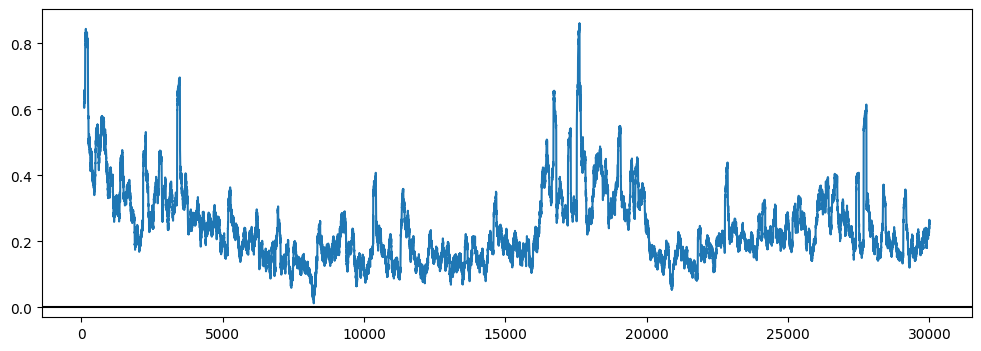

In [372]:
logr = np.log(rock['mid_price'] / rock['mid_price'].shift(1))
realized_vol = logr.rolling(100).std() * np.sqrt(10000 * 250)

plt.figure(figsize=(12, 4))
plt.plot(realized_vol - call_2['implied_vol'])
plt.axhline(0, c='k')
plt.show()

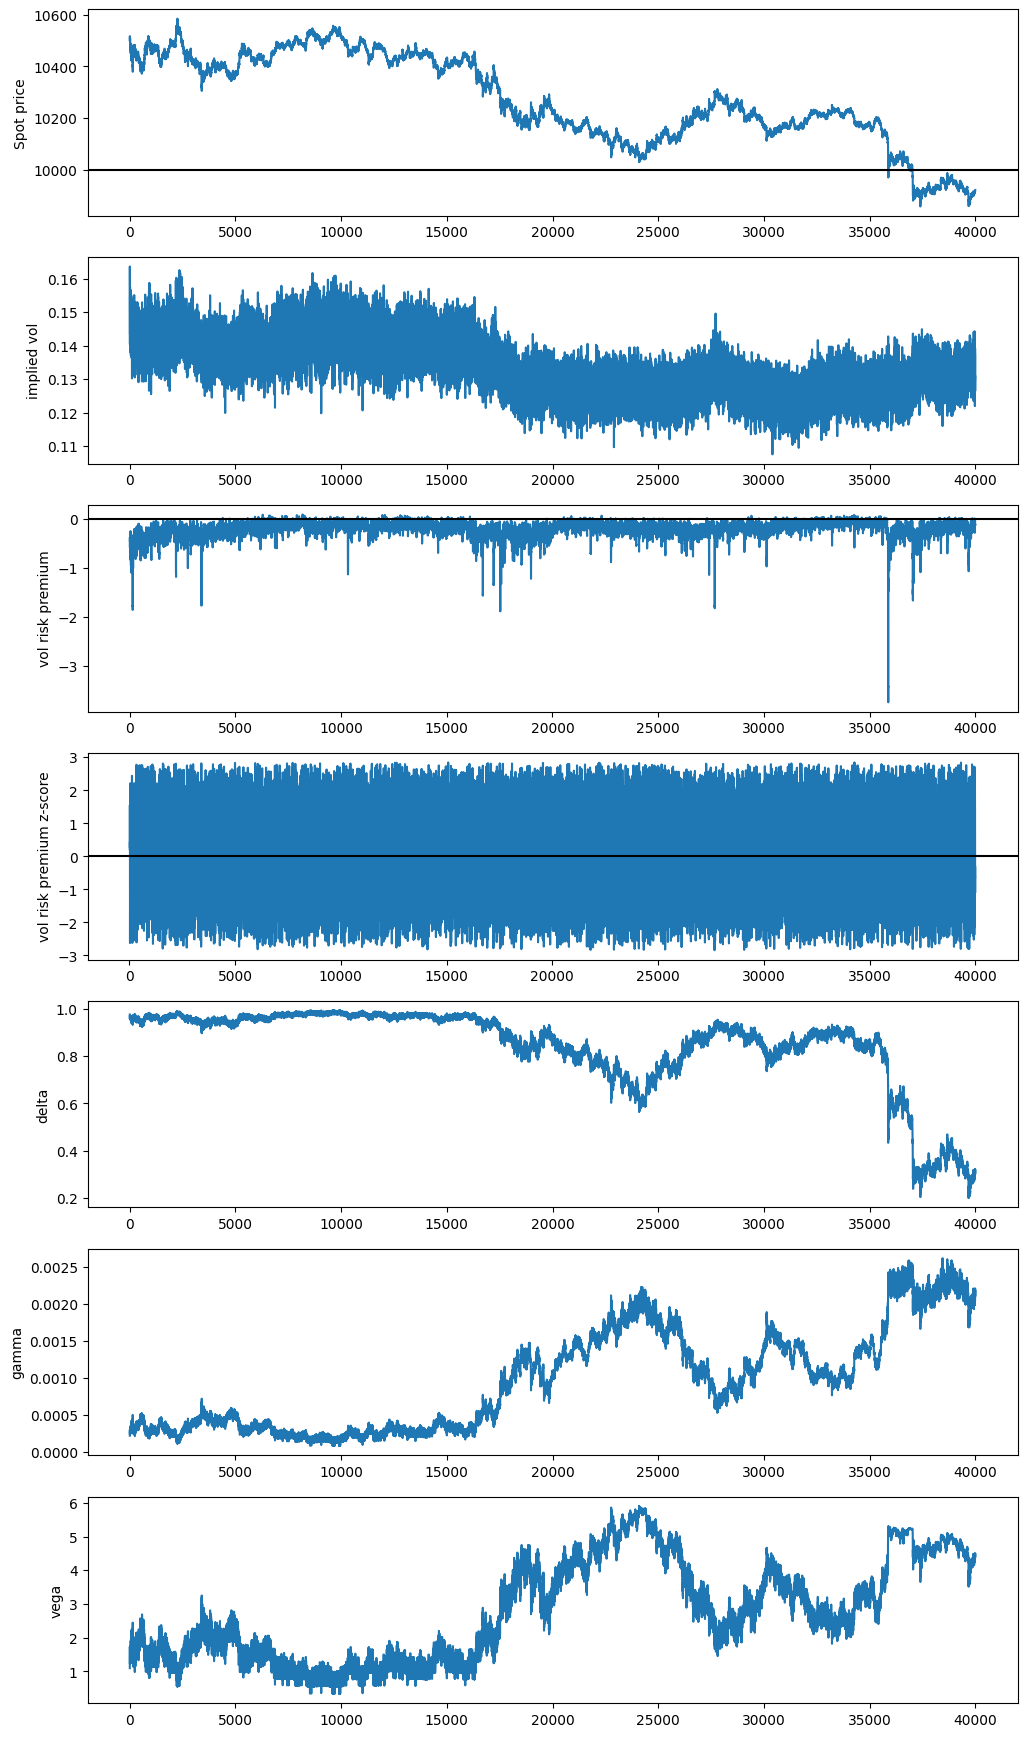

In [50]:
call = call_2
w = 10

logr = np.log(rock['mid_price'] / rock['mid_price'].shift(1))
realized_vol = logr.rolling(w).std() * np.sqrt(10000 * 250)
vol_spread = call['implied_vol'] - realized_vol
vol_spread_zscore = (vol_spread - vol_spread.rolling(w).mean()) / vol_spread.rolling(w).std()

fig, ax = plt.subplots(7, 1, figsize=(12, 22))
ax[0].plot(call['spot'])
ax[0].set_ylabel('Spot price')
ax[0].axhline(call.iloc[0]['strike'], c='k')
ax[1].plot(call['implied_vol'])
ax[1].set_ylabel('implied vol')
ax[2].plot(vol_spread)
ax[2].axhline(0, c='k')
ax[2].set_ylabel('vol risk premium')
ax[3].plot(vol_spread_zscore)
ax[3].axhline(0, c='k')
ax[3].set_ylabel('vol risk premium z-score')
ax[4].plot(call['delta'])
ax[4].set_ylabel('delta')
ax[5].plot(call['gamma'])
ax[5].set_ylabel('gamma')
ax[6].plot(call['vega'])
ax[6].set_ylabel('vega')
plt.show()

In [210]:
products = [rock, call_0, call_1, call_2, call_3, call_4]

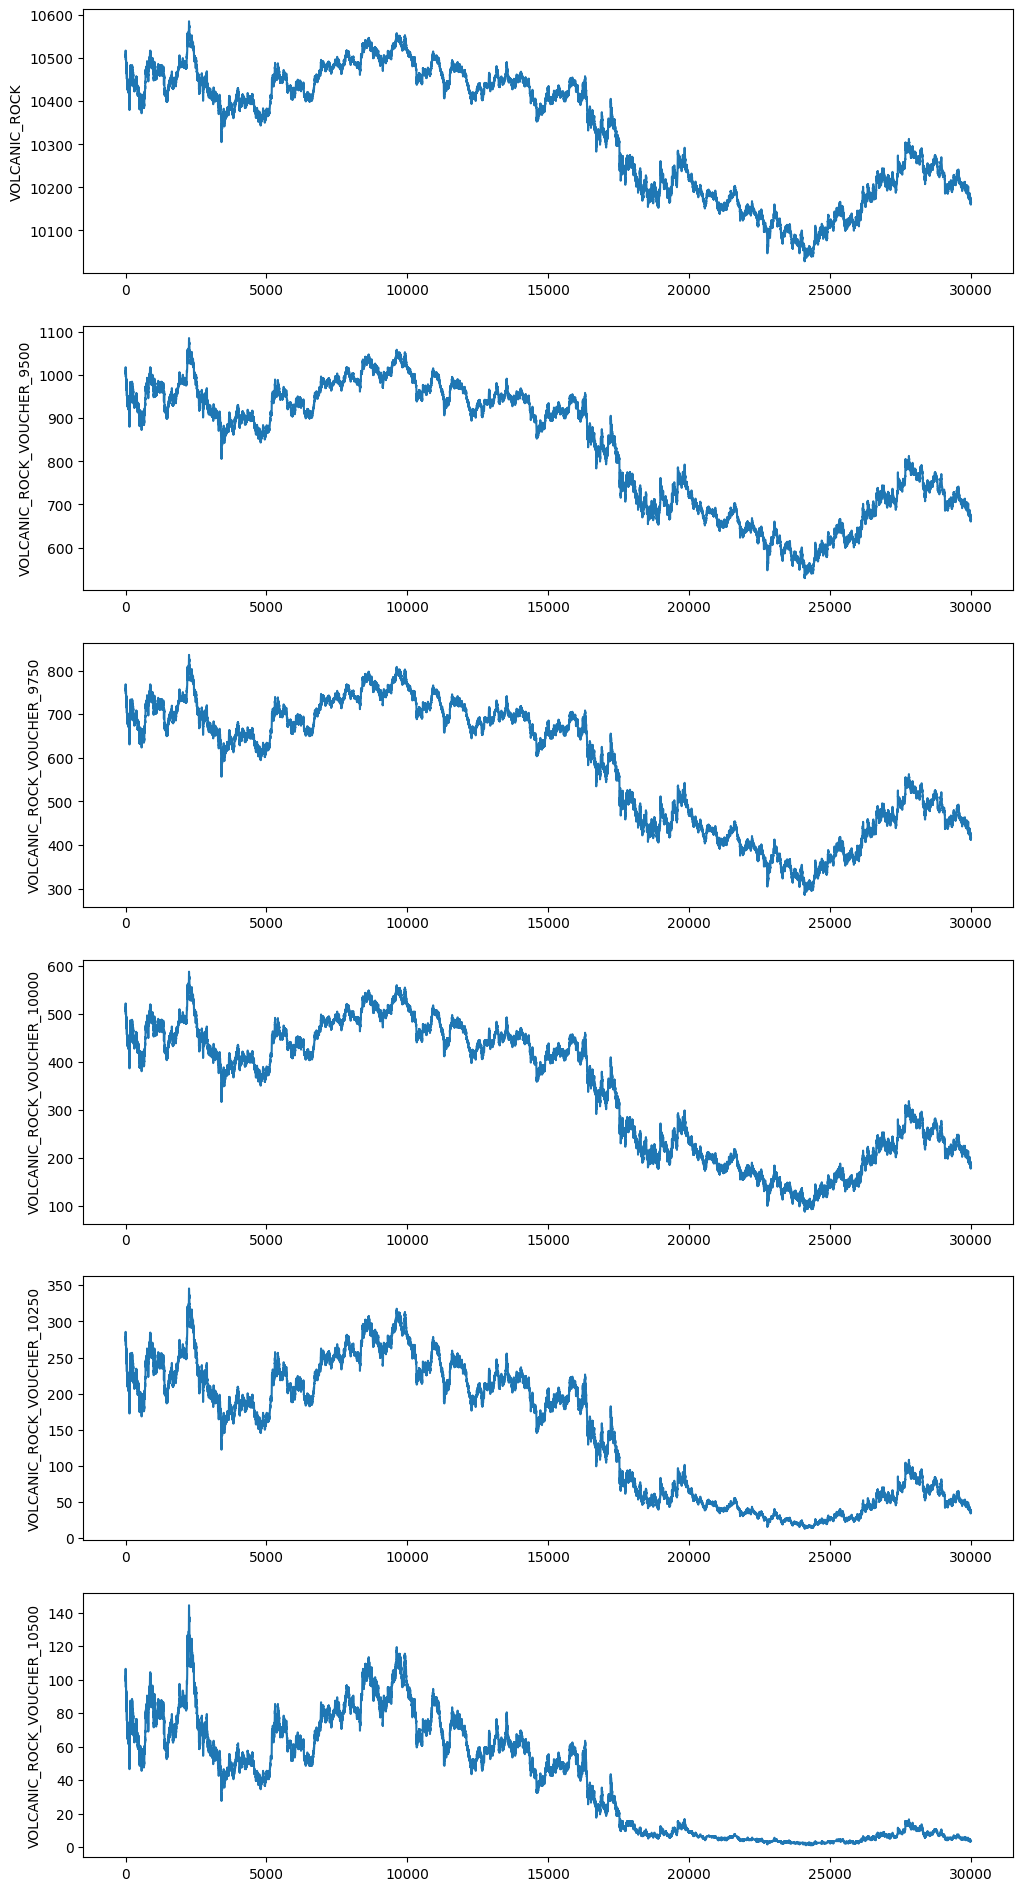

In [211]:
fig, ax = plt.subplots(6, 1, figsize=(12, 24))
for i, prod in enumerate(products):
    ax[i].plot(prod['mid_price'])
    ax[i].set_ylabel(prod['product'].iloc[0])
plt.show()

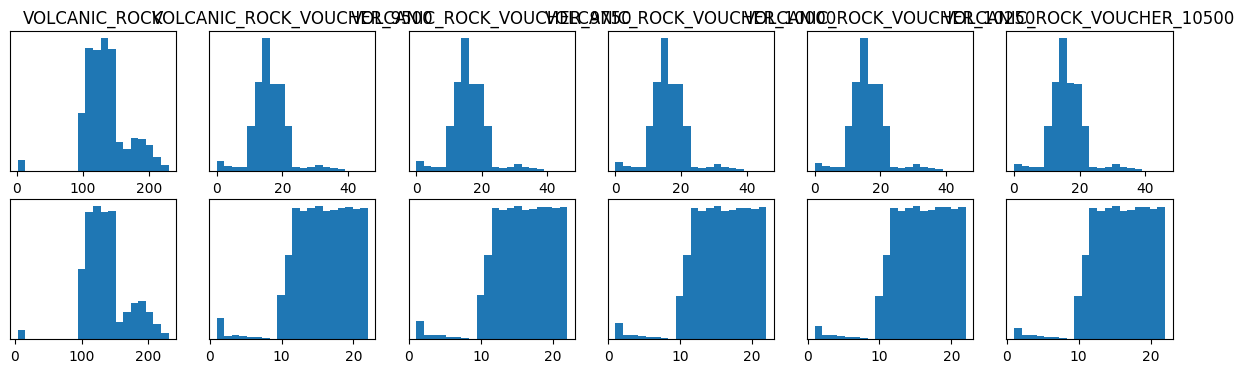

In [163]:
fig, ax = plt.subplots(2, 6, figsize=(15, 4))
for i, prod in enumerate(products):
    ax[0, i].hist(prod['bid_volume_1'], bins=20)
    ax[1, i].hist(prod['ask_volume_1'], bins=20)
    ax[0, i].set_title(prod.iloc[0]['product'])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
plt.show()

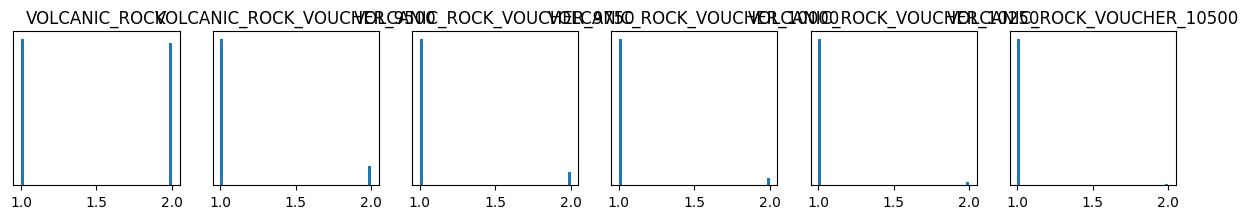

In [164]:
fig, ax = plt.subplots(1, 6, figsize=(15, 2))
for i, prod in enumerate(products):
    ax[i].hist(prod['ask_price_1'] - prod['bid_price_1'], bins=50)
    ax[i].set_title(prod.iloc[0]['product'])
    ax[i].set_yticks([])
plt.show()

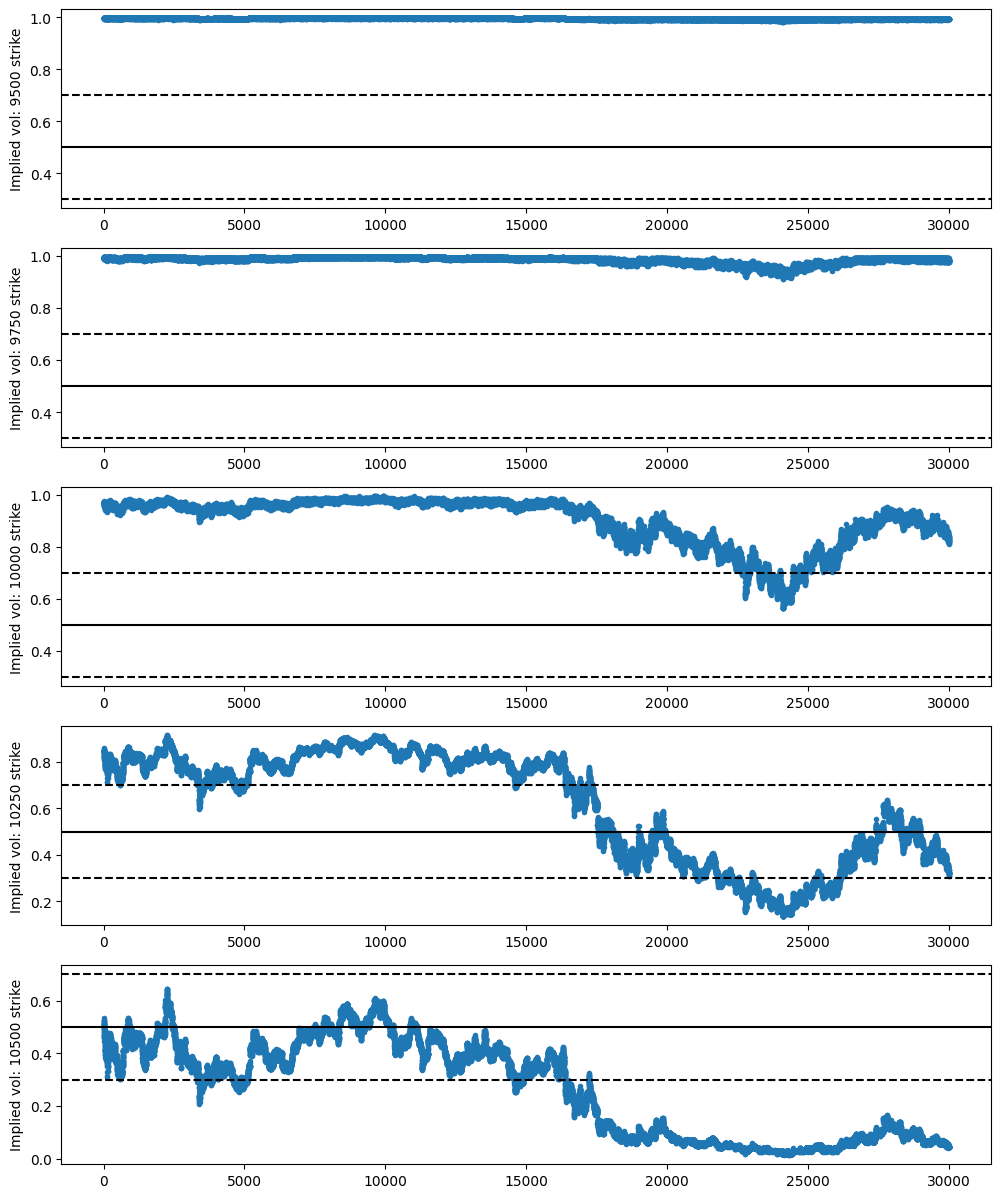

In [335]:
fig, ax = plt.subplots(5, 1, figsize=(12, 15))
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i].scatter(np.arange(len(call)), call['delta'], marker='.')
    ax[i].set_ylabel(f'Implied vol: {call.iloc[0]['strike']} strike')
    ax[i].axhline(0.5, c='k')
    ax[i].axhline(0.3, c='k', linestyle='dashed')
    ax[i].axhline(0.7, c='k', linestyle='dashed')
plt.show()

In [172]:
call_0[call_0['implied_vol'] <= 0.1]['implied_vol']

8        0.071875
9        0.071875
14       0.071875
15       0.071875
18       0.071875
           ...   
29991    0.071875
29994    0.071875
29995    0.071875
29998    0.071875
29999    0.071875
Name: implied_vol, Length: 12578, dtype: float64

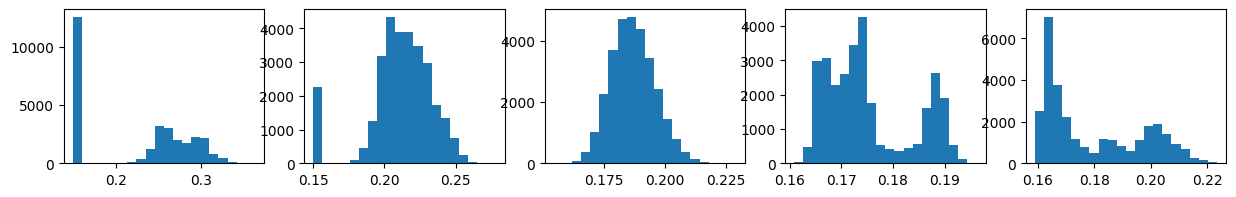

In [130]:
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i].hist(call['implied_vol'], bins=20)
plt.show()

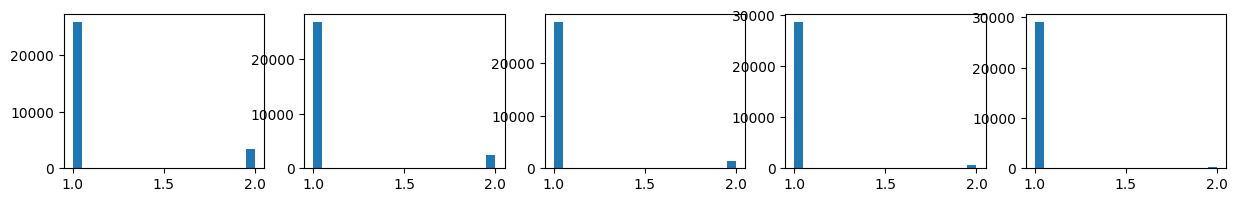

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i].hist(call['ask_price_1'] - call['bid_price_1'], bins=20)
plt.show()

In [10]:
# for prod in products:
#     logr = np.log(prod['mid_price']) - np.log(prod['mid_price'].shift(1))
#     logr = logr.dropna()
#     fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#     plot_acf(logr, ax=ax[0], zero=False)
#     plot_pacf(logr, ax=ax[1], zero=False)
#     ax[0].set_xlim([0, 15])
#     ax[1].set_xlim([0, 15])
#     ax[0].set_ylabel(prod.iloc[0]['product'])
#     plt.show()

# Round 5

## VOLCANIC_ROCK

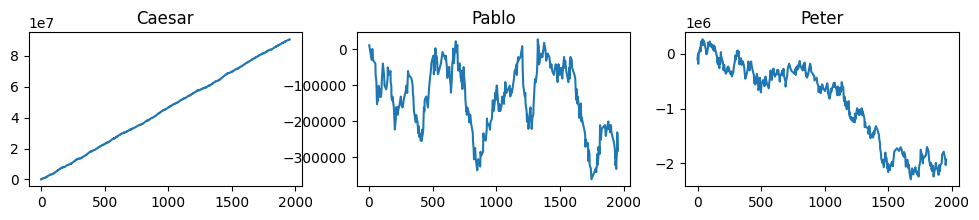

In [19]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'VOLCANIC_ROCK']
price_1 = price_1[price_1['product'] == 'VOLCANIC_ROCK']
price_2 = price_2[price_2['product'] == 'VOLCANIC_ROCK']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'VOLCANIC_ROCK']
trades_1 = trades_1[trades_1['symbol'] == 'VOLCANIC_ROCK']
trades_2 = trades_2[trades_2['symbol'] == 'VOLCANIC_ROCK']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(1, 3, figsize=(12, 2))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()

## VOLCANIC_ROCK_VOUCHER_9500

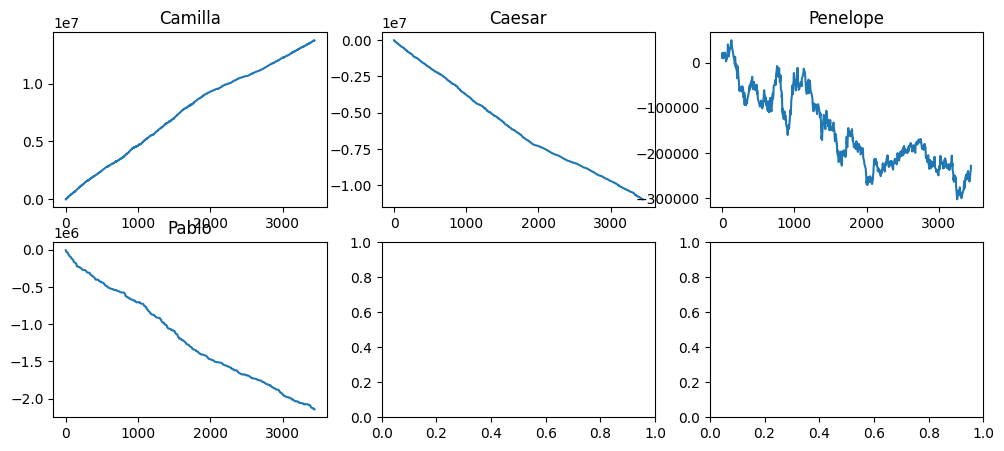

In [20]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'VOLCANIC_ROCK_VOUCHER_9500']
price_1 = price_1[price_1['product'] == 'VOLCANIC_ROCK_VOUCHER_9500']
price_2 = price_2[price_2['product'] == 'VOLCANIC_ROCK_VOUCHER_9500']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'VOLCANIC_ROCK_VOUCHER_9500']
trades_1 = trades_1[trades_1['symbol'] == 'VOLCANIC_ROCK_VOUCHER_9500']
trades_2 = trades_2[trades_2['symbol'] == 'VOLCANIC_ROCK_VOUCHER_9500']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()

## VOLCANIC_ROCK_VOUCHER_9750

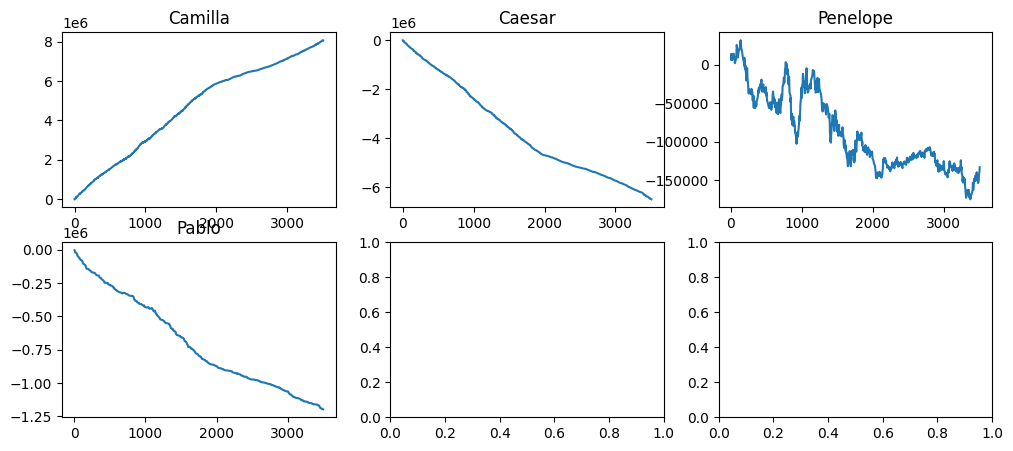

In [21]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'VOLCANIC_ROCK_VOUCHER_9750']
price_1 = price_1[price_1['product'] == 'VOLCANIC_ROCK_VOUCHER_9750']
price_2 = price_2[price_2['product'] == 'VOLCANIC_ROCK_VOUCHER_9750']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'VOLCANIC_ROCK_VOUCHER_9750']
trades_1 = trades_1[trades_1['symbol'] == 'VOLCANIC_ROCK_VOUCHER_9750']
trades_2 = trades_2[trades_2['symbol'] == 'VOLCANIC_ROCK_VOUCHER_9750']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()

## VOLCANIC_ROCK_VOUCHER_10000

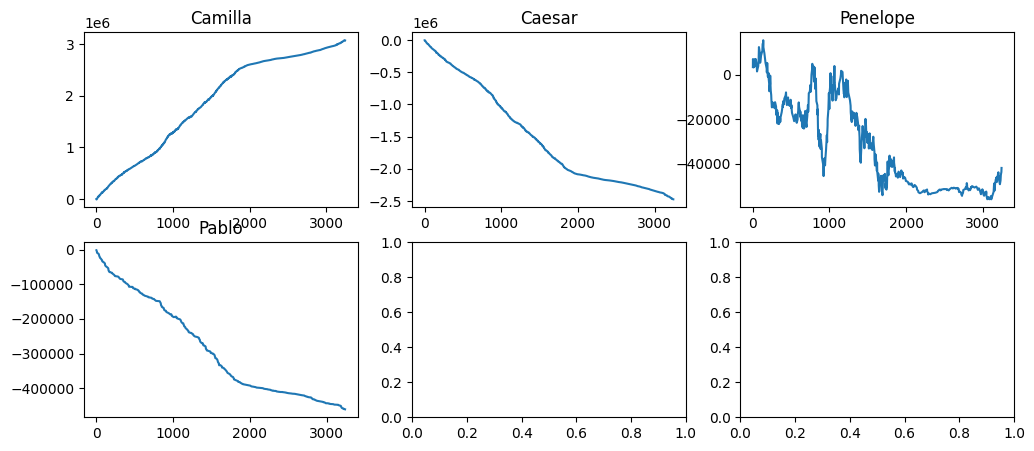

In [22]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']
price_1 = price_1[price_1['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']
price_2 = price_2[price_2['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10000']
trades_1 = trades_1[trades_1['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10000']
trades_2 = trades_2[trades_2['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10000']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()

## VOLCANIC_ROCK_VOUCHER_10250

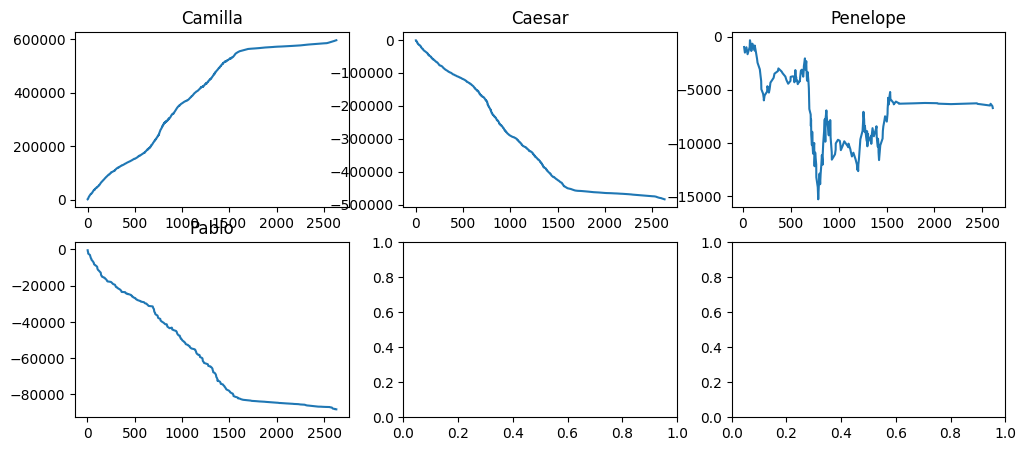

In [23]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'VOLCANIC_ROCK_VOUCHER_10250']
price_1 = price_1[price_1['product'] == 'VOLCANIC_ROCK_VOUCHER_10250']
price_2 = price_2[price_2['product'] == 'VOLCANIC_ROCK_VOUCHER_10250']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10250']
trades_1 = trades_1[trades_1['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10250']
trades_2 = trades_2[trades_2['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10250']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()

## VOLCANIC_ROCK_VOUCHER_10500

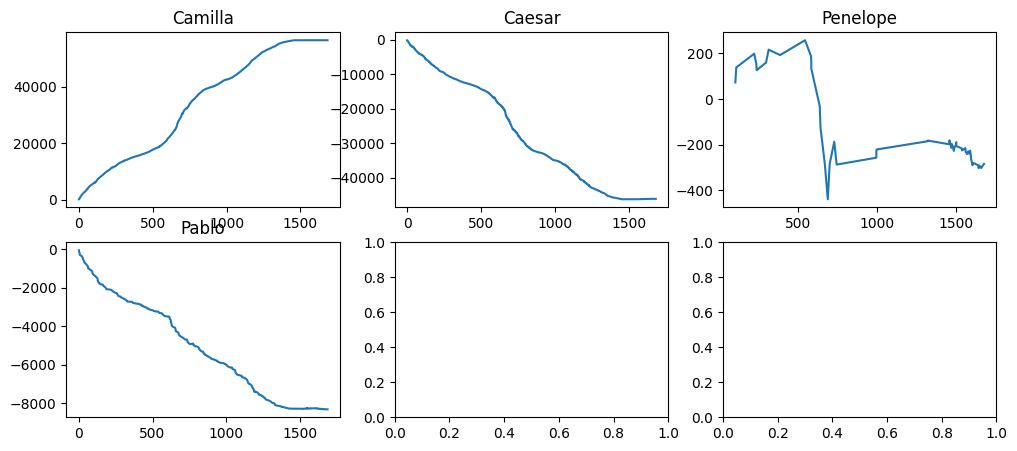

In [24]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']
price_1 = price_1[price_1['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']
price_2 = price_2[price_2['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10500']
trades_1 = trades_1[trades_1['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10500']
trades_2 = trades_2[trades_2['symbol'] == 'VOLCANIC_ROCK_VOUCHER_10500']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()